# Experiments for FISTA restart


First experiment:
$$\min\limits_{x\in R^N} \frac{1}{2}\|Ax-b\|^2_2+\rho\|x\|_1.$$

In [1]:
import numpy as np
import scipy as scp
import pylab as pyl
import pywt
import matplotlib.pyplot as plt
from PIL import Image
import time
import requests
from io import BytesIO
from algorithms import *
from visualizer import *

In [2]:
def operators_LASSO(A,b,lam):
    ATA=A.T.dot(A)
    ATb=A.T.dot(b)
    f = lambda x: 1/2*npl.norm(np.dot(A,x)-b)**2
    h = lambda x: lam*npl.norm(x,1)
    F = lambda x: 1/2*npl.norm(np.dot(A,x)-b)**2+lam*npl.norm(x,1)
    Df = lambda x: np.dot(ATA,x)-ATb
    proxh = lambda x,s:(x/(np.absolute(x)+1*(x==0)))*(np.absolute(x)-s*lam)*(np.absolute(x)-s*lam>0)
    return F,f,h,Df,proxh

In [25]:
N=2000
A=100*np.random.rand(N,N)
b=100*np.random.rand(N)
lam=10
x0=(np.random.rand(N)-0.5)*100
exit_crit=lambda x,xm:npl.norm(x-xm,2) #exit criteria -> norm of the composite gradient without the normalization
sp=lambda x,y:np.dot(x,y) #scalar product
F,f,h,Df,proxh=operators_LASSO(A,b,lam)
ATA=A.T.dot(A)
xmin=npl.inv(ATA).dot(np.dot(A.T,b))
L=np.max(np.absolute(npl.eig(A.T.dot(A))[0]))

In [26]:
Niter=60000
epsilon=1e-12

In [27]:
xFB,costFB,ctimeFB=ForwardBackward(x0,1/L,Niter,epsilon,Df,proxh,F=F,exit_crit=exit_crit,track_ctime=True)
Plot_FB=To_Plot(costFB,"Forward-Backward, exact value of $L$.",ctimeFB)

In [28]:
xFISTA,costFISTA,ctimeFISTA=FISTA(x0,1/L,Niter,epsilon,Df,proxh,F=F,exit_crit=exit_crit,track_ctime=True)
Plot_FISTA=To_Plot(costFISTA,"FISTA, exact value of $L$.",ctimeFISTA)

In [29]:
xAR1,costAR1,ctimeAR1=FISTA_automatic_restart(x0,1/L,Niter,epsilon,Df,proxh,F,exit_crit=exit_crit,track_ctime=True)
Plot_AR1=To_Plot(costAR1,"Automatic restart FISTA ADLR, exact value of $L$.",ctimeAR1)

In [30]:
xRG,costRG,ctimeRG=FISTA_grad_restart(x0,1/L,Niter,epsilon,Df,proxh,F=F,exit_crit=exit_crit,sp=sp,track_ctime=True)
Plot_RG=To_Plot(costRG,"Empiric gradient restart.",ctimeRG)

In [31]:
xRF,costRF,ctimeRF=FISTA_func_restart(x0,1/L,Niter,epsilon,Df,proxh,F=F,exit_crit=exit_crit,out_cost=True,track_ctime=True)
Plot_RF=To_Plot(costRF,"Empiric restart, rule on F.",ctimeRF)

In [32]:
n0=10
xAKL,costAKL,ctimeAKL=FISTA_restart_AKL(x0,1/L,Niter,n0,epsilon,Df,proxh,F,exit_crit=exit_crit,out_cost=True,track_ctime=True)
Plot_AKL=To_Plot(costAKL,"Adaptive restart by Alamo, Krupa and Limon.",ctimeAKL)

In [33]:
xAKLg,costAKLg,ctimeAKLg=FISTA_gradient_restart_AKL(x0,1/L,Niter,epsilon,Df,proxh,F=F,exit_crit=exit_crit,track_ctime=True)
Plot_AKLg=To_Plot(costAKLg,"Adaptive gradient restart by Alamo, Krupa and Limon.",ctimeAKLg)

In [38]:
Global_Plot=[Plot_FB,Plot_FISTA,Plot_RG,Plot_RF,Plot_AKL,Plot_AKLg,Plot_AR1]

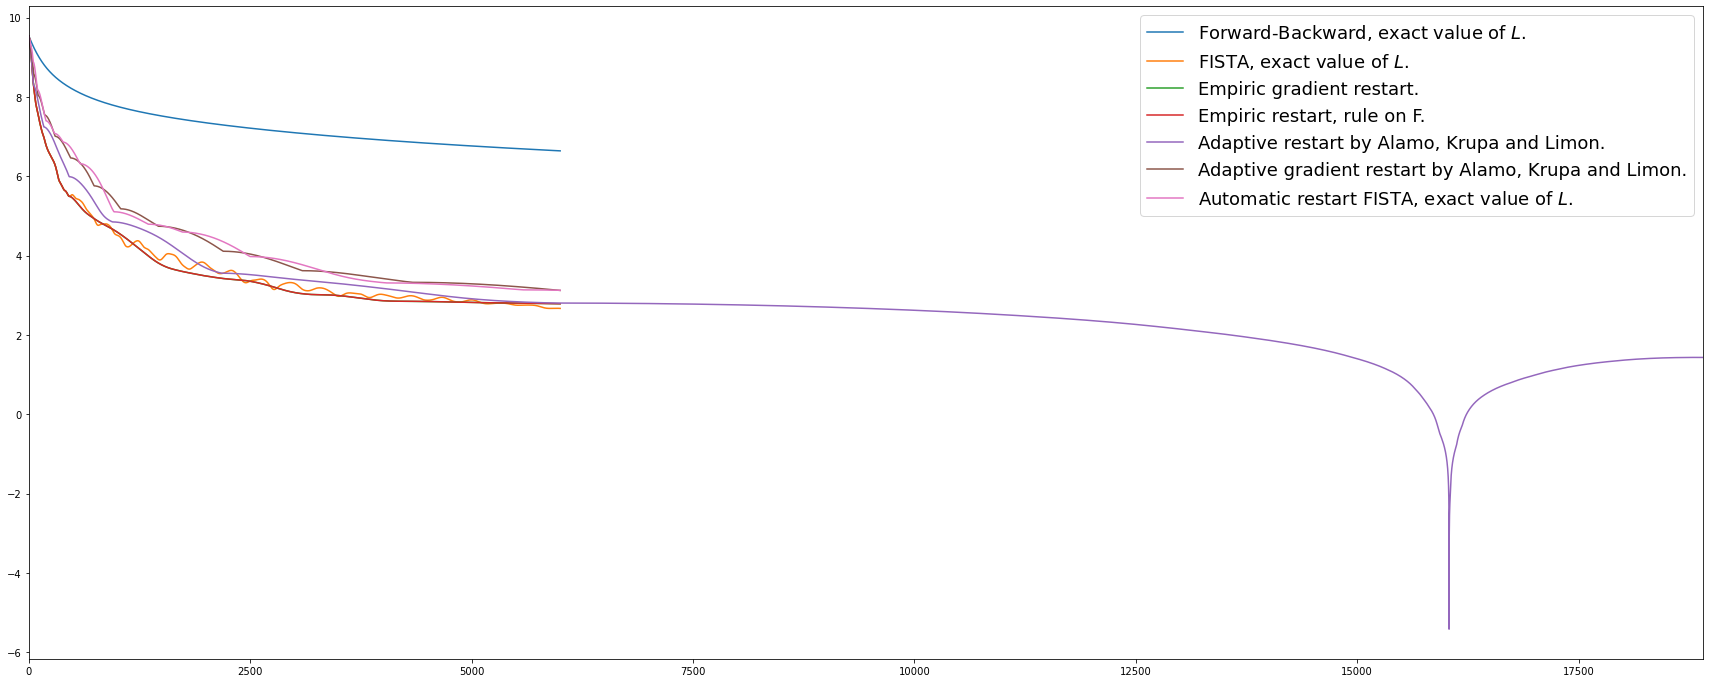

In [39]:
Plot(Global_Plot)

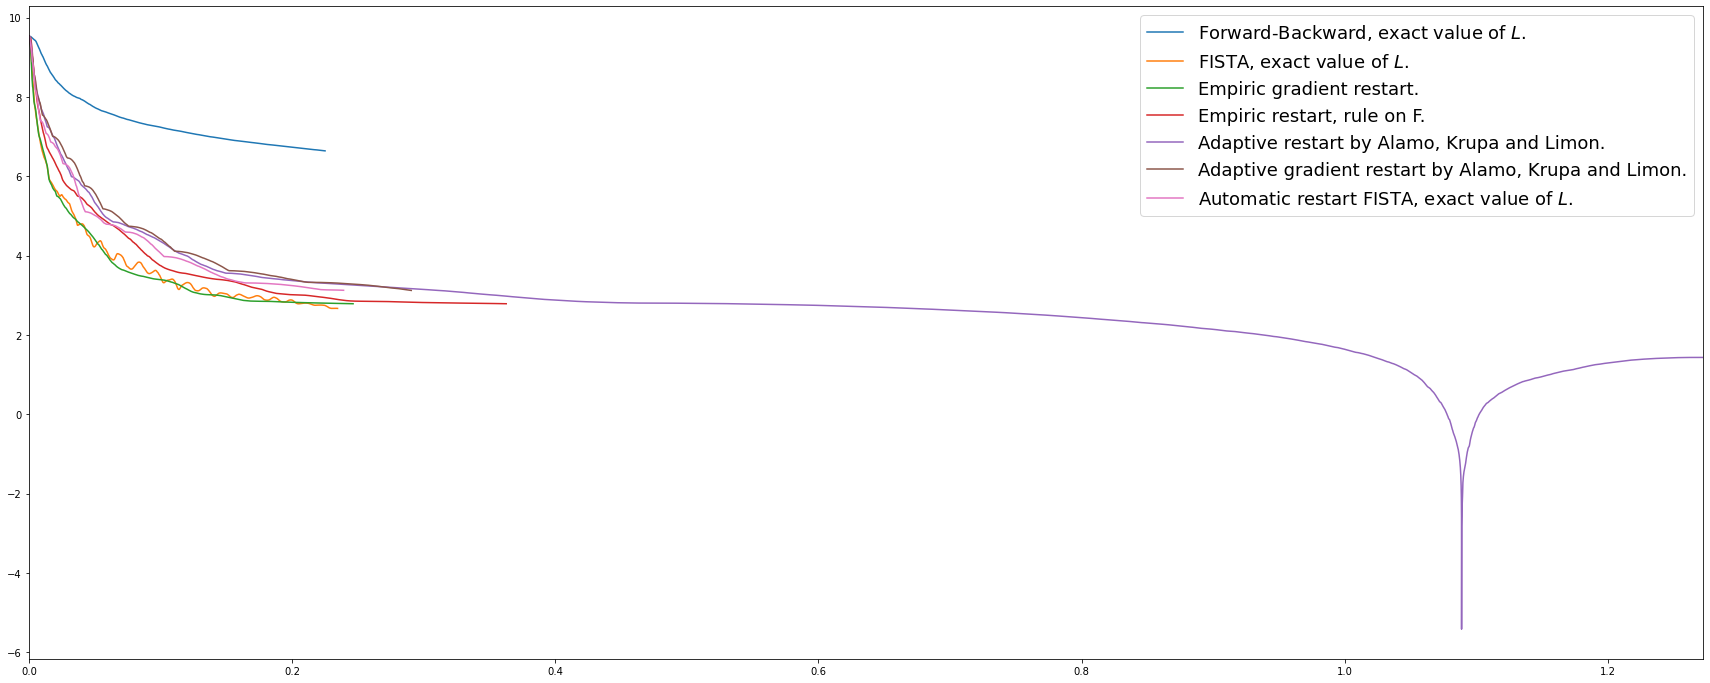

In [40]:
Plot(Global_Plot,ite=False)